### Installs and Imports

In [1]:
%%capture output
# execute in Colab once per session to install packages
!pip install torchinfo
!pip install pytorch-lightning
!pip install torchmetrics

# uncomment to see output
# print(output)

In [2]:
# imports and settings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import os

from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

from utils import PrintMetricsCallback, denormalize, sample_dataset, process_experiment_logs

# Chapter 6 Textbook Investigations

We're going to mimic the investigations done in Chapter 6 of "Inside Deep Learning" with a few changes:
* Use CIFAR-10 instead of FashionMNIST (it's a little harder and is easy to overfit).
* Use PyTorch Lightning instead of plain PyTorch.
* Include downsampling the dataset for faster investigation.  There is a flag to enable this.
* Include augmentation to help with overfitting.  There is a flag for this too.

We'll include 5 models from the text:
1.  CNN with 3 multilayer convolution blocks, tanh() activations, and a single linear layer for the classifer.
2.  Same as 1 but change to LeakyReLU() activations
3.  Same as 2 but add batch normalization after every convolutional layer
4.  Same as 3 but add skip connections within each multilayer convolution block
5.  Similar to 3 but add residual connections and bottlenecks.

## Part 0 - Preliminaries

In [3]:
use_augmentation = True
original_mean = [0] # set for each channel
original_std = [1] # for each channel
original_mean = (0.4914, 0.4822, 0.4465)
original_std = (0.2023, 0.1994, 0.2010)

batch_size = 400
use_subsets = False
num_each_class = 500
workers = 2
seed = 42 # random seed for downsampling

# training and validation transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(), # Converts to Tensor and scales pixels between 0 and 1
        transforms.Normalize(mean = original_mean, std = original_std)
    ])

if not use_augmentation:
    train_transform = valid_transform
else:
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        valid_transform,
    ])  

# load the datasets and apply transforms
train_set = CIFAR10(root='./data', train = True, download = True, transform = train_transform )
valid_set = CIFAR10(root='./data', train = False, download = True, transform = valid_transform )
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(valid_set)}")

# downsample the datasets if desired
if use_subsets:
    train_set = sample_dataset(train_set, num_samples=num_each_class, random_state=seed)
    valid_set = sample_dataset(valid_set, num_samples=num_each_class, random_state=seed)
    print(f"Sampled Training set size: {len(train_set)}")
    print(f"Sampled Validation set size: {len(valid_set)}")

# build the dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                         num_workers=workers, persistent_workers=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False,
                         num_workers=workers, persistent_workers=True)


Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000


In [4]:
# configure optimizer and  learning rate scheduler

# optimizer parameters
lr = 0.001
weight_decay = 1e-5

# scheduler parameters
max_lr = None # if None no scheduler will be used
epochs = 20
steps_per_epoch = len(train_loader)

Since we'll use the same `LightningModule` for all of our experiments we define it once here.  For each experiment we'll instantiate it with the latest version of our CNN `nn.Module`.

In [5]:
class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.01, weight_decay=1e-4, max_lr = 0.01, epochs = 8, steps_per_epoch=125):

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_lr = max_lr
        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        #optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.weight_decay,momentum=0.9)
        if self.max_lr:
            scheduler = {'scheduler': OneCycleLR(optimizer, max_lr=self.max_lr, steps_per_epoch=self.steps_per_epoch, epochs=self.epochs),
                         'interval': 'step', 'frequency': 1}
            #scheduler = OneCycleLR(optimizer, max_lr=self.max_lr, epochs=self.epochs, steps_per_epoch=self.steps_per_epoch)
            return [optimizer], [scheduler]
        return optimizer


For each new network we'll train the model for 10 epochs while printing metrics.  The metrics will be logged to a csv file is processed into a dataframe for viewing and plotting.  Since these steps will be the same for each new network we'll explore.  We'll include the process in a function so we can reuse it for each experiment.  You'll need to pass in your root save path, a short name for your experiment, and an instance of your LightningModule that includes your network and information about training.

In [6]:
def run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1):
    model_dir = root_save_dir + '/' + exper_name + '/Models'
    csv_logs_dir = root_save_dir + '/' + exper_name + '/CSVLogs'
    
    # define our callbacks
    print_cb = PrintMetricsCallback(print_epoch=1)
    model_save_cb = ModelCheckpoint( 
        dirpath = model_dir,
        filename = exper_name+'-{epoch:02d}-{valid_acc:.2f}',
        monitor='valid_acc', 
        mode='max')

    if verbose > 0:
        all_cbs = [print_cb, model_save_cb]
    else:
        all_cbs = [model_save_cb]
    
    # setup the trainer
    logger = CSVLogger(csv_logs_dir,name="model") # don't change name = "model"
    
    trainer = pl.Trainer(max_epochs=max_epochs,
                         enable_progress_bar=False,
                         callbacks=all_cbs,
                         num_sanity_val_steps=0,
                         val_check_interval=1.0,
                         logger=logger,
                         gradient_clip_val = 0.1,
                         gradient_clip_algorithm="value"
                          )
    
    # train the model!
    trainer.fit(light_model, train_loader, valid_loader)

    # process the logs
    df = process_experiment_logs(csv_logs_dir, exper_name)

    return df

def plot_valid_acc(df):
    sns.lineplot(data=df, x='epoch',y='valid_acc',hue='exp_name')
    plt.title('Validation Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

In [7]:
#Whats the width and height of our images?
W, H = 32, 32
#How many values are in the input? We use this to help determine the size of subsequent layers
D = W*H # total pixels
#Hidden layer size
n = 256 
#How many channels are in the input?
C = 3
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10

# Inside Deep Learning - Chapter 6 Experiments

## Vanilla CNN

This is the "vanilla" CNN on page 201.  It has:
* 8 convolutional layers with tanh() activation functions
* The convolution layers are organized into blocks of 3 or 2 layers.
* Maxpool between the blocks.
* Simple linear classifier at the end.
* 415,114 parameters

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/CIFAR10/CNN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 415 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.660     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [400, 3, 32, 32]          [400, 10]                 --
├─Conv2d: 1-1                            [400, 3, 32, 32]          [400, 32, 32, 32]         896
├─Tanh: 1-2                              [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Conv2d: 1-3                            [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
├─Tanh: 1-4                              [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Conv2d: 1-5                            [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
├─Tanh: 1-6                              [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─MaxPool2d: 1-7                         [400, 32, 32, 32]         [400, 32, 16, 16]         --
├─Conv2d: 1-8                            [400, 32, 16, 16]         [400, 64, 16, 16]         18,496
├─Tanh: 1-9             

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20 Metrics: valid_loss: 0.6853, valid_acc: 0.7569, train_loss: 0.7642, train_acc: 0.7338, LR: 1.000000e-03
End.  Trained for 20 epochs.


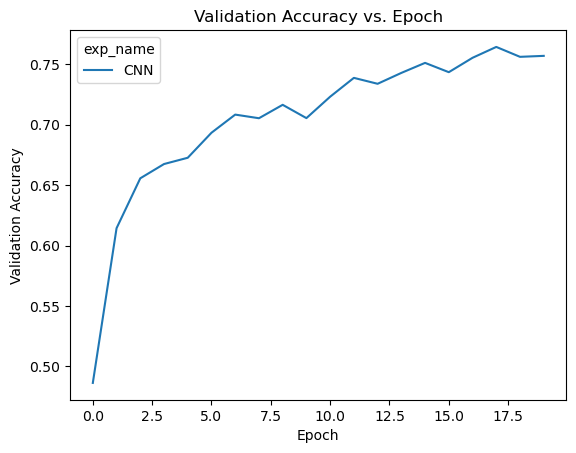

,epoch,valid_loss,valid_acc,train_loss,train_acc,exp_name
0,0,1.402842,0.4863,1.674157,0.38780,CNN
1,1,1.104399,0.6143,1.313073,0.52914,CNN
2,2,0.986616,0.6556,1.173804,0.58546,CNN
3,3,0.956917,0.6674,1.105339,0.61272,CNN
4,4,0.944551,0.6726,1.053949,0.62978,CNN
5,5,0.882973,0.6933,1.016549,0.64450,CNN
6,6,0.857690,0.7083,0.977757,0.65766,CNN
7,7,0.848044,0.7053,0.947515,0.66866,CNN
8,8,0.811422,0.7164,0.923769,0.67654,CNN
9,9,0.845274,0.7054,0.904103,0.68276,CNN


In [8]:
# Vanilla CNN

cnn_model = nn.Sequential(
    nn.Conv2d(C, n_filters, 3, padding=1),             nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),     nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),     nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), nn.Tanh(),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_model, input_size = (batch_size,C,W,H), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN"
root_save_dir = './CIFAR10'
light_model = BasicLightningModel(cnn_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)
plot_valid_acc( pd.concat([cnn_results]) )
display(cnn_results)

## Better activation functions

Same as Vanilla CNN, but the tanh() activations are changed to LeakyReLU().

* Page 209

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/CIFAR10/CNN_ReLU/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 415 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.660     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [400, 3, 32, 32]          [400, 10]                 --
├─Sequential: 1-1                        [400, 3, 32, 32]          [400, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [400, 3, 32, 32]          [400, 32, 32, 32]         896
│    └─LeakyReLU: 2-2                    [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Sequential: 1-2                        [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
│    └─LeakyReLU: 2-4                    [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Sequential: 1-3                        [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    └─Conv2d: 2-5                       [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
│    └─LeakyReLU: 2-6       

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20 Metrics: valid_loss: 0.4151, valid_acc: 0.8600, train_loss: 0.3752, train_acc: 0.8701, LR: 1.000000e-03
End.  Trained for 20 epochs.


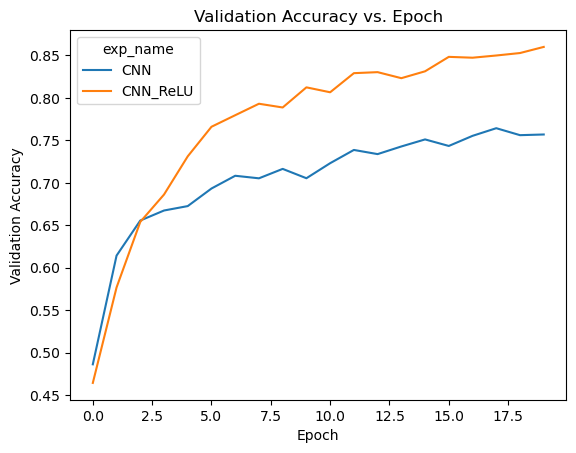

In [9]:
# CNN + LeakyReLU

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.LeakyReLU(leak_rate)
    )

cnn_relu_model = nn.Sequential(
    cnnLayer(C, n_filters), cnnLayer(n_filters), cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), cnnLayer(2*n_filters), cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_relu_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ReLU"
root_save_dir = './CIFAR10'

light_model = BasicLightningModel(cnn_relu_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_relu_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)

plot_valid_acc( pd.concat([cnn_results, cnn_relu_results]) )

## Including batch normalization

This is the same as the last network with LeakyReLU activations, but now we add batch normalization after each convolutional layer. (page 215)

Each BatchNorm2d() layer adds 2*(number of output channels) for 416,202 parameters.

This addition gives a boost in early training, but ultimately doesn't improve the overall validation accuracy.  (NOTE: the pictures and results in the book are wrong for this chapter.  The author used the training data for the validation set which is an example of "data leakage."

Batch normalization doesn't increase the representation ability of your network, it just makes it easier/faster to train. (See page 222).

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/CIFAR10/CNN_BN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [400, 3, 32, 32]          [400, 10]                 --
├─Sequential: 1-1                        [400, 3, 32, 32]          [400, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [400, 3, 32, 32]          [400, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [400, 32, 32, 32]         [400, 32, 32, 32]         64
│    └─LeakyReLU: 2-3                    [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Sequential: 1-2                        [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    └─Conv2d: 2-4                       [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
│    └─BatchNorm2d: 2-5                  [400, 32, 32, 32]         [400, 32, 32, 32]         64
│    └─LeakyReLU: 2-6                    [400, 32, 32, 32]         [400, 32, 32, 32]         --
├─Sequential: 1-3              

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20 Metrics: valid_loss: 0.5413, valid_acc: 0.8307, train_loss: 0.3200, train_acc: 0.8887, LR: 1.000000e-03
End.  Trained for 20 epochs.


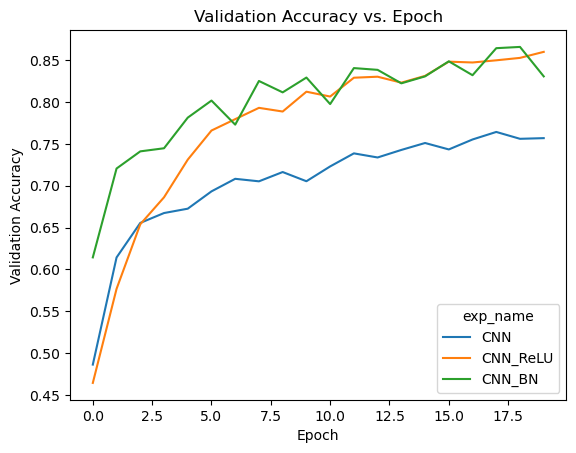

In [10]:
# CNN + BatchNorm + LeakyReLU

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.BatchNorm2d(out_filters), #The only change, adding BatchNorm2d after our convolution!
        nn.LeakyReLU(leak_rate)
    )

cnn_bn_model = nn.Sequential(
    cnnLayer(C, n_filters), cnnLayer(n_filters), cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), cnnLayer(2*n_filters), cnnLayer(2*n_filters), 
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_bn_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_BN"
root_save_dir = './CIFAR10'

light_model = BasicLightningModel(cnn_bn_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_bn_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)
plot_valid_acc( pd.concat([cnn_results, cnn_relu_results, cnn_bn_results]) )

## Skip connections for better training

The idea here is to add shortcuts for easier information flow forward and backward through the network to improve training.  

* read more details on pages 224-230
* our network is a more straightforward implementation of the network on page 230
* we'll draw this out and discuss it in class
* it's an important design principle for larger networks
* only gives a slight improvement in our small network
* 656,138 parameters (most of the increase is due to an added convolutional layer at the end)
* Densenet is an important architecture introduced in 2016 which uses all possible skip connections within each block:

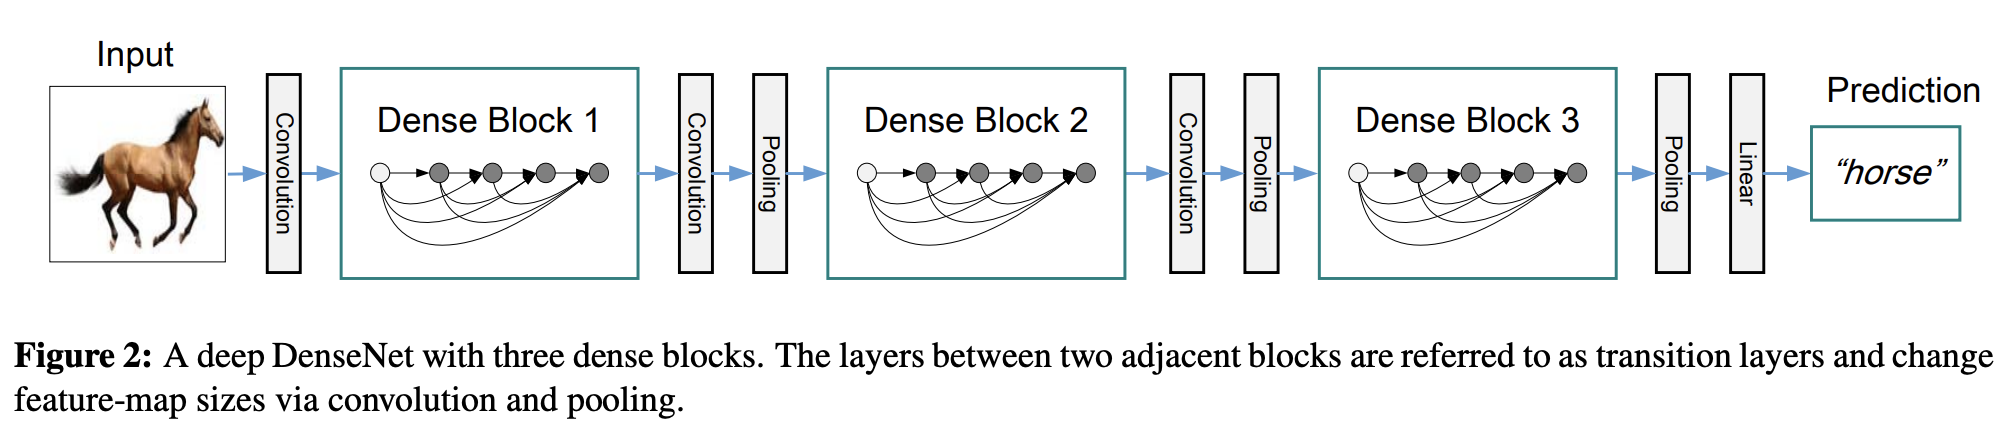

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/CIFAR10/CNN_BN_Skip/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 656 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
656 K     Trainable params
0         Non-trainable params
656 K     Total params
2.625     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [400, 3, 32, 32]          [400, 10]                 --
├─Conv2d: 1-1                            [400, 3, 32, 32]          [400, 32, 32, 32]         896
├─SkipConv2d: 1-2                        [400, 32, 32, 32]         [400, 64, 32, 32]         --
│    └─Sequential: 2-1                   [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
│    │    └─BatchNorm2d: 3-2             [400, 32, 32, 32]         [400, 32, 32, 32]         64
│    │    └─LeakyReLU: 3-3               [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    └─Sequential: 2-2                   [400, 32, 32, 32]         [400, 32, 32, 32]         --
│    │    └─Conv2d: 3-4                  [400, 32, 32, 32]         [400, 32, 32, 32]         9,248
│    │    └─BatchNorm2d: 3-5

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20 Metrics: valid_loss: 0.4717, valid_acc: 0.8552, train_loss: 0.2677, train_acc: 0.9069, LR: 1.000000e-03
End.  Trained for 20 epochs.


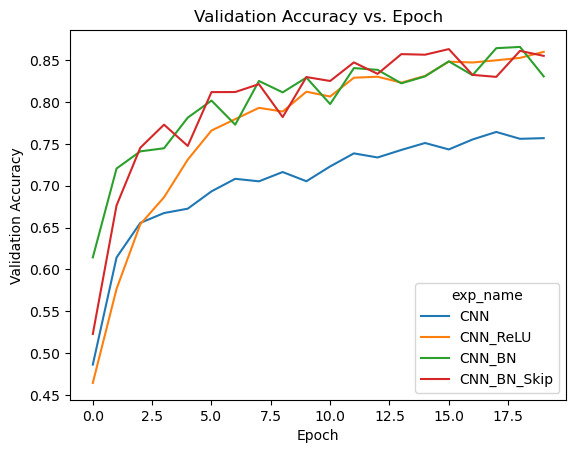

In [11]:
# CNN + BatchNorm + LeakyReLU + Skip Connections

# Note:  the book book has more general code for creating skip blocks of arbitrary length
# we've simplified the code to create a particular example

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.BatchNorm2d(out_filters), #The only change, adding BatchNorm2d after our convolution!
        nn.LeakyReLU(leak_rate)
    )

class SkipConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = cnnLayer(in_channels, in_channels)
        self.conv2 = cnnLayer(in_channels, in_channels)
        self.conv3 = cnnLayer(2*in_channels, 2*in_channels)

    def forward(self,x):
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3( torch.cat([out1, out2], dim=1) )
        return out3

cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1), 
    SkipConv2d(n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(2*n_filters, 4*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(4*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_skip_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_BN_Skip"
root_save_dir = './CIFAR10'

light_model = BasicLightningModel(cnn_skip_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_skip_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)
plot_valid_acc( pd.concat([cnn_results, cnn_relu_results, cnn_bn_results, cnn_skip_results]) )

## Adding residual connections

* starts on page 233
* the network below is on page 240
* there are multiple new ingredients here that we'll discuss in class
    * 1x1 convolutions for changing the number of channels
    * residual connections (variation on skip connections)
    * residual bottlenecks
* total of 544,696 parameters

### 1x1 convolutions
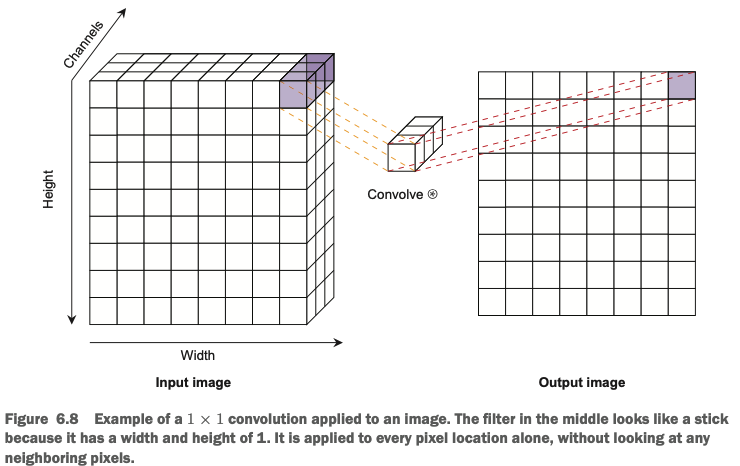

### Residual Blocks
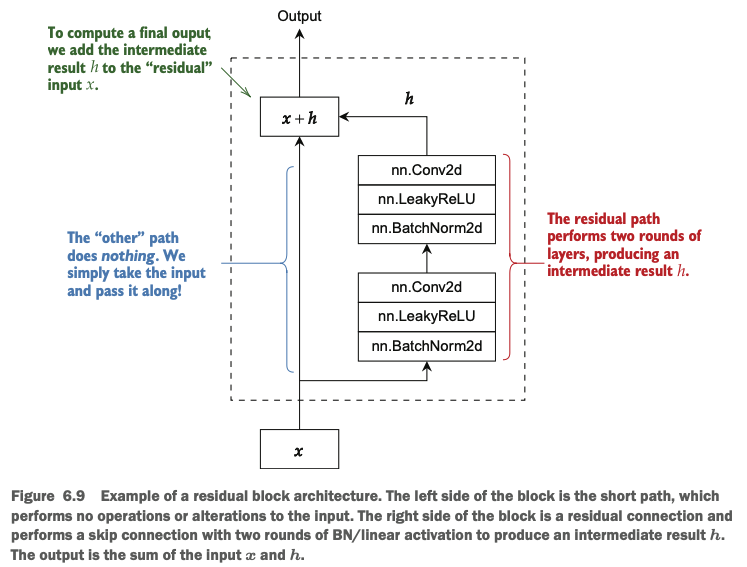

### Residual Bottlenecks
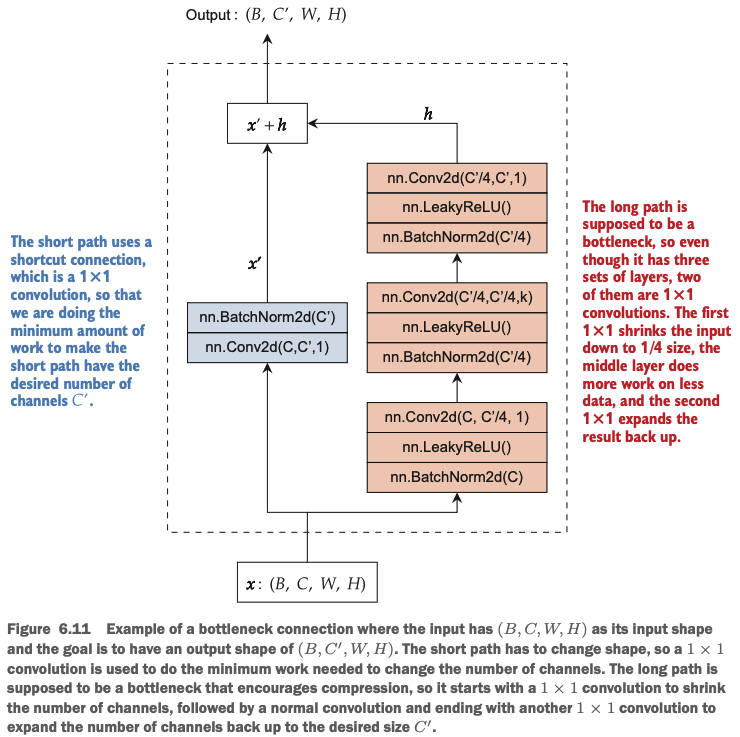

In [ ]:
# CNN + BatchNorm + LeakyReLU + Residual 

class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )
     
    def forward(self, x):
        return x + self.F(x) #F() has all the work for the long path, we just add it to the input

class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 

leak_rate = 0.1

cnn_resnetXX_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters), #BottleNeck to start because we need more channels. It's also common to start with just one normal hidden layer before starting residual blocks. 
    nn.LeakyReLU(leak_rate), #We are inserting an activation after each residual. This is optional. 
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_resnetXX_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ResXX"
root_save_dir = './CIFAR10'

light_model = BasicLightningModel(cnn_resnetXX_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_resnetXX_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)
plot_valid_acc( pd.concat([cnn_results, cnn_skip_results, cnn_resnetXX_results]) )

## Resnet9

The Resnet9 architecture is described in [this blog](https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/).  Here is a picture of this architecture that we'll discuss in class:

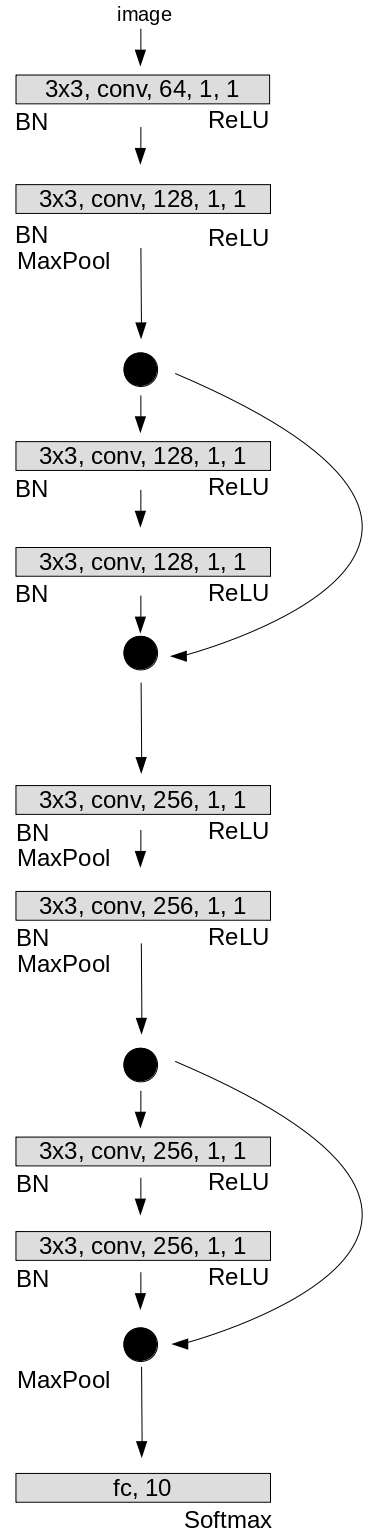

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/CIFAR10/CNN_Resnet9/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Resnet9            | 6.6 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.301    Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Resnet9                                  [400, 3, 32, 32]          [400, 10]                 --
├─Sequential: 1-1                        [400, 3, 32, 32]          [400, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [400, 3, 32, 32]          [400, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [400, 64, 32, 32]         [400, 64, 32, 32]         128
│    └─ReLU: 2-3                         [400, 64, 32, 32]         [400, 64, 32, 32]         --
├─Sequential: 1-2                        [400, 64, 32, 32]         [400, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [400, 64, 32, 32]         [400, 128, 32, 32]        73,856
│    └─BatchNorm2d: 2-5                  [400, 128, 32, 32]        [400, 128, 32, 32]        256
│    └─ReLU: 2-6                         [400, 128, 32, 32]        [400, 128, 32, 32]        --
│    └─MaxPool2d: 2-7     

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20 Metrics: valid_loss: 0.3762, valid_acc: 0.8853, train_loss: 0.1676, train_acc: 0.9421, LR: 1.000000e-03
End.  Trained for 20 epochs.


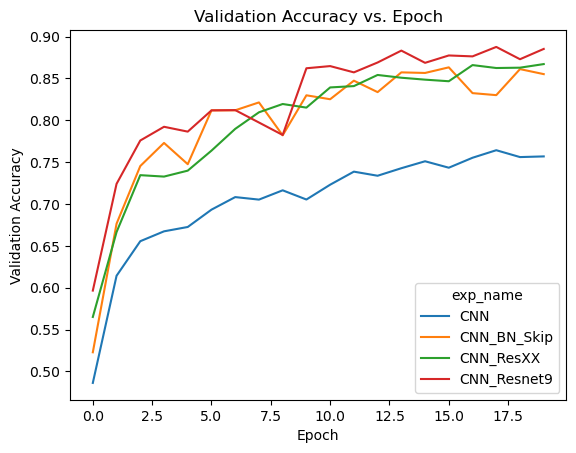

In [13]:
# simple Resnet9 https://jovian.ml/aakashns/05b-cifar10-resnet

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

cnn_resnet9_model = Resnet9(3,10)

summary_str = summary(cnn_resnet9_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_Resnet9"
root_save_dir = './CIFAR10'

light_model = BasicLightningModel(cnn_resnet9_model, num_classes = 10,
                                  lr=lr, weight_decay=weight_decay, 
                                  max_lr = max_lr, epochs = epochs, 
                                  steps_per_epoch=steps_per_epoch)

cnn_resnet9_results = run_experiment(light_model, root_save_dir, exper_name, max_epochs=epochs, verbose = 1)
plot_valid_acc( pd.concat([cnn_results, cnn_skip_results, cnn_resnetXX_results, cnn_resnet9_results]) )